En el campus encontrará el archivo “datos_para_clustering.mat” que contiene una matriz de datos de 500 mediciones de una variable de 100 dimensiones.

In [9]:
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')

raw = sio.loadmat('datos_para_clustering.mat')['datos']
print('Forma de los datos:', raw.shape)


Forma de los datos: (500, 100)


In [10]:
class Kohonen:
    def __init__(self, grid_shape=(15, 15), input_dim=100, learning_rate=0.7, radius=None, semilla=0):
        self.grid_shape = grid_shape
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.rng = np.random.default_rng(semilla)
        self.weights = self.rng.uniform(-1, 1, size=(*grid_shape, input_dim))
        self.initial_radius = radius if radius is not None else max(grid_shape) / 2
        self.initial_radius = max(self.initial_radius, 1.0)

    def _winner(self, sample):
        distances = np.linalg.norm(self.weights - sample, axis=2)
        return np.unravel_index(np.argmin(distances), self.grid_shape)

    def _neighborhood(self, winner_index, radius):
        gx, gy = np.indices(self.grid_shape)
        dist_sq = (gx - winner_index[0]) ** 2 + (gy - winner_index[1]) ** 2
        return np.exp(-dist_sq / (2 * (radius ** 2)))

    def train(self, data, iteraciones=15000):
        time_constant = iteraciones / np.log(self.initial_radius)
        for epoch in range(iteraciones):
            sample = data[self.rng.integers(0, len(data))]
            lr = self.learning_rate * np.exp(-epoch / iteraciones)
            radius = self.initial_radius * np.exp(-epoch / time_constant)
            radius = max(radius, 1.0)
            winner = self._winner(sample)
            influence = self._neighborhood(winner, radius)[..., None]
            self.weights += influence * lr * (sample - self.weights)

    def transform(self, data):
        coords = []
        for sample in data:
            winner = self._winner(sample)
            coords.append(winner)
        return np.array(coords)

    def u_matrix(self):
        m, n, _ = self.weights.shape
        u = np.zeros((m, n))
        for i in range(m):
            for j in range(n):
                neighbors = []
                for di, dj in ((-1, 0), (1, 0), (0, -1), (0, 1)):
                    ni, nj = i + di, j + dj
                    if 0 <= ni < m and 0 <= nj < n:
                        neighbors.append(np.linalg.norm(self.weights[i, j] - self.weights[ni, nj]))
                u[i, j] = np.mean(neighbors) if neighbors else 0.0
        return u

### Entrenamiento del mapa y proyección a 2D

In [ ]:
som = Kohonen(grid_shape=(18, 18), input_dim=raw.shape[1], learning_rate=0.4, semilla=None)
som.train(raw, iteraciones=30000)

projections = som.transform(raw)
print('Proyecciones en la grilla:', projections.shape)

### Matriz U para analizar clusters

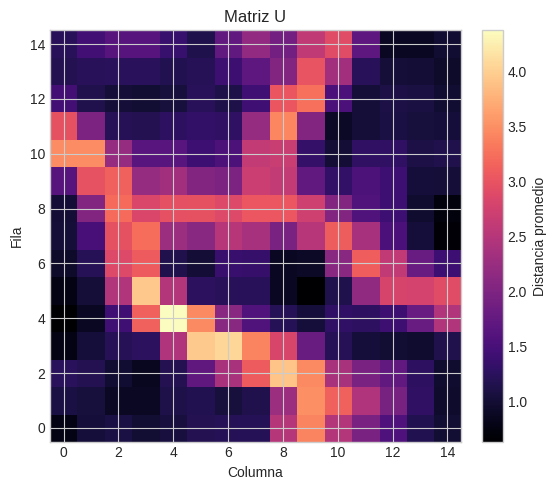

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
umatrix = som.u_matrix()
im = ax.imshow(umatrix, cmap='magma', origin='lower')
ax.set_title('Matriz U')
ax.set_xlabel('Columna')
ax.set_ylabel('Fila')
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Distancia promedio')
plt.tight_layout()
fig.savefig('/home/camila/Documents/Redes Neuronales/Redes-Neuronales/TP3/ejercicio-3/graficos/heatmap-3', dpi=200, bbox_inches='tight')
plt.show()
